In [1]:
from premise import *
import bw2data
bw2data.projects.set_current("ecoinvent-3.11-consequential")
#bw2data.projects.set_current("ecoinvent-3.8-cutoff")
#bw2data.projects.set_current("ecoinvent-3.9.1-cutoff_bw25")
#clear_cache()
scenarios = [
    {"model": "remind", "pathway": "SSP2-rollBack", "year": 2050},
    {"model": "image", "pathway": "SSP2-VLHO", "year": 2050},
    {"model": "tiam-ucl", "pathway": "SSP2-RCP19", "year": 2050},
]

ndb = NewDatabase(
        scenarios=scenarios,
        source_db="ecoinvent-3.11-consequential",
        source_version="3.11",
        biosphere_name="ecoinvent-3.11-biosphere",
        key='tUePmX_S5B8ieZkkM7WUU2CnO8SmShwmAeWK9x2rTFo=',
        system_model="consequential",
        keep_imports_uncertainty=False,
        keep_source_db_uncertainty=False
)

premise v.(2, 3, 0, 'dev1')
+------------------------------------------------------------------+
| Warning                                                          |
+------------------------------------------------------------------+
| Because some of the scenarios can yield LCI databases            |
| containing net negative emission technologies (NET),             |
| it is advised to account for biogenic CO2 flows when calculating |
| Global Warming potential indicators.                             |
| `premise_gwp` provides characterization factors for such flows.  |
| It also provides factors for hydrogen emissions to air.          |
|                                                                  |
| Within your Brightway project:                                   |
| from premise_gwp import add_premise_gwp                          |
| add_premise_gwp()                                                |
+------------------------------------------------------------------+
+-----

In [2]:
%%time
ndb.update()

Processing scenarios for all sectors:   0%|     | 0/3 [00:00<?, ?it/s]

Creating markets for petrol, low-sulfur
Has diesel_blend attribute
Creating markets for diesel, low-sulfur
Creating markets for natural gas


Processing scenarios for all sectors:  33%|▎| 1/3 [01:07<02:14, 67.17s

Creating markets for petrol, low-sulfur
Has diesel_blend attribute
Creating markets for diesel, low-sulfur
No DAC scenario data available -- skipping
No EWR scenario data available -- skipping
No two-wheeler fleet scenario data available -- skipping


Processing scenarios for all sectors:  67%|▋| 2/3 [02:20<01:11, 71.01s

Creating markets for petrol, low-sulfur
Has diesel_blend attribute
Creating markets for diesel, low-sulfur
Creating markets for kerosene
Creating markets for liquefied petroleum gas
Creating markets for natural gas
No buildings heat scenario data available -- skipping
No industrial heat scenario data available -- skipping
No EWR scenario data available -- skipping
No two-wheeler fleet scenario data available -- skipping


Processing scenarios for all sectors: 100%|█| 3/3 [03:31<00:00, 70.52s

Done!

CPU times: user 3min 19s, sys: 6.72 s, total: 3min 25s
Wall time: 3min 31s


In [ ]:
ndb.scenarios[2]["iam data"].natural_gas_blend

In [3]:
from premise.activity_maps import mapping_to_dataframe

In [7]:
df = mapping_to_dataframe(
    ndb.scenarios[0]
)

In [8]:
df.to_excel("mapping0.xlsx")

In [6]:
ndb.scenarios[0]["iam data"].biomass_mix.sel(region="LAM")

<xarray.DataArray 'value' (variables: 2, year: 1)> Size: 16B
array([[0.],
       [0.]])
Coordinates:
    region     <U3 12B 'LAM'
  * variables  (variables) <U29 232B 'biomass - residual' 'biomass crops - pu...
  * year       (year) int64 8B 2050
Attributes:
    unit:     {'SE|Electricity|Biomass|Energy Crops': 'EJ/yr', 'SE|Electricit...

In [3]:
ndb.generate_change_report()

Generate change report.
Report saved under /Users/romain/GitHub/premise/dev/export/change reports/.


In [3]:
ndb.write_db_to_olca()

Write Simapro import file(s) for OpenLCA.
Running all checks...
Minor anomalies found: check the change report.
The following exchanges have not been used in the Simapro export:
+---------------------------------------+---------+----------------------------------+----------+
|                  Name                 | Product |            Categories            | Location |
+---------------------------------------+---------+----------------------------------+----------+
|      Non-hazardous waste disposed     |         | ('inventory indicator', 'waste') |   None   |
|   Organic carbon, placed in landfill  |         | ('inventory indicator', 'waste') |   None   |
| Waste mass, total, placed in landfill |         | ('inventory indicator', 'waste') |   None   |
|        Hazardous waste disposed       |         | ('inventory indicator', 'waste') |   None   |
+---------------------------------------+---------+----------------------------------+----------+
569 unmatched flow categories. Check u

In [4]:
ndb.scenarios[0]["iam data"].gains_data_IAM.sel(region="EUR").coords["sector"].values

array(['AACID', 'CEMENT', 'CHEM', 'CHEMBULK', 'CUSM',
       'End_Use_Industry_Bio_Trad', 'End_Use_Industry_Coal',
       'End_Use_Industry_HLF', 'End_Use_Industry_LLF',
       'End_Use_Industry_NatGas', 'End_Use_Residential_Bio_Mod',
       'End_Use_Residential_Bio_Trad_Cook',
       'End_Use_Residential_Bio_Trad_Heat',
       'End_Use_Residential_Coal_Cook', 'End_Use_Residential_Coal_Heat',
       'End_Use_Residential_HLF', 'End_Use_Residential_LLF',
       'End_Use_Residential_NatGas', 'End_Use_Services_Bio_Trad_Heat',
       'End_Use_Services_Coal_Heat', 'End_Use_Transport_AGR_HLF',
       'End_Use_Transport_Coal', 'End_Use_Transport_HDT_HLF',
       'End_Use_Transport_HDT_LLF', 'End_Use_Transport_LDT_HLF',
       'End_Use_Transport_LDT_LLF', 'End_Use_Transport_MC_LLF',
       'End_Use_Transport_NatGas', 'End_Use_Transport_OFF_HLF',
       'End_Use_Transport_OFF_LLF', 'Losses_Coal',
       'Losses_Distribution_Use', 'Losses_Prod_Conventional_Gas',
       'Losses_Prod_Oil', 'Losses_

In [4]:
df = ndb.scenarios[0]["iam data"].gains_data_IAM.sel(region="EUR", sector="End_Use_Transport_LDT_HLF", pollutant=[
    'PM25', 'PM1', 'PM10'
]).to_dataframe("val").reset_index()

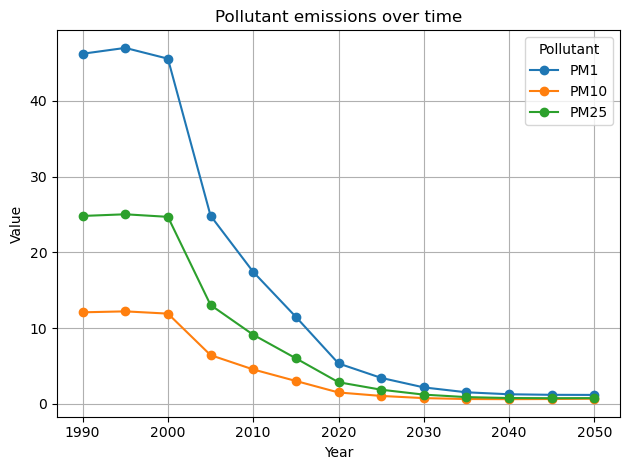

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

pivot_df = df.pivot_table(index='year', columns='pollutant', values='val')

# Plot
pivot_df.plot(marker='o')
plt.title('Pollutant emissions over time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Pollutant')
plt.grid(True)
#plt.ylim(0, 3)
plt.tight_layout()
plt.show()

In [1]:
from premise.score_comparison import comparative_analysis
import bw2data
bw2data.projects.set_current("ecoinvent-3.11-cutoff")

In [2]:
[m for m in bw2data.methods if "matter" in str(m)]

[('EF v3.0 no LT',
  'particulate matter formation no LT',
  'impact on human health no LT'),
 ('EF v3.0', 'particulate matter formation', 'impact on human health'),
 ('EF v3.1 no LT',
  'particulate matter formation no LT',
  'impact on human health no LT'),
 ('EF v3.1', 'particulate matter formation', 'impact on human health'),
 ('EN15804+A2 - Additional impact categories and indicators',
  'particulate matter formation',
  'impact on human health'),
 ('Inventory results and indicators',
  'emissions to air',
  'total particulate matter'),
 ('Inventory results and indicators',
  'emissions to air',
  'particulate matter, < 2.5 um'),
 ('Inventory results and indicators',
  'emissions to air',
  'particulate matter, >2.5 um and <10'),
 ('Inventory results and indicators',
  'emissions to air',
  'particulate matter >10 um'),
 ('ReCiPe 2016 v1.03, endpoint (E) no LT',
  'human health no LT',
  'particulate matter formation no LT'),
 ('ReCiPe 2016 v1.03, endpoint (E)',
  'human health',


In [6]:
df = comparative_analysis(
    databases=[
        "ecoinvent-3.11-cutoff",
        "ei_cutoff_3.11_remind_SSP2-rollBack_2050 2025-07-21"
    ],
    indicators=[
        ('Inventory results and indicators', 'emissions to air', 'total particulate matter'),
    ],
    direct_only=True,
    limit=None
)

Processing ecoinvent-3.11-cutoff: 100%|███| 25412/25412 [19:21<00:00, 21.88it/s]
Processing ei_cutoff_3.11_remind_SSP2-rollBack_2050 2025-07-21: 100%|█| 27799/27


In [8]:
df.to_excel("PMs.xlsx")

In [2]:
ndb.scenarios[0]["inventories metadata cache filepath"]

PosixPath('/Users/romain/Library/Application Support/premise/cache/cached_230dev1_ecoinvent-3.11-cutoff_wo_uncertainty_inventories.pickle (metadata).cache')

In [3]:
import pickle

with open(ndb.scenarios[0]["database metadata cache filepath"], "rb") as f:
    metadata = pickle.load(f)


In [4]:
list(metadata.items())[2000]

(('market for residues, MSWI[F]-WWT, WW from maize starch production',
  'residues, MSWI[F]-WWT, WW from maize starch production',
  'CH'),
 {'classifications': [('ISIC rev.4 ecoinvent',
    '3821:Treatment and disposal of non-hazardous waste'),
   ('CPC',
    '39320: Ash and residue (except from the manufacture of iron or steel), containing metals or metallic compounds, excep[…]')],
  'comment': "This is a market activity, representing a treatment mix. In the case of products needing treatment, market mixes are supplied by the activities treating the product in the geography defined by the market, and they supply the activities needing to treat the product, as they have generated it as a by-product in the Undefined processes (present as a negative input in system models). Transport to the treating facility or losses are also accounted in this type of markets, when relevant.\nThis is the market for 'residues, MSWI[F]-WWT, WW from maize starch production', in the geography of Switzerlan

In [3]:
ndb.write_db_to_brightway()

Write new database(s) to Brightway.
Running all checks...
Minor anomalies found: check the change report.
Database ei_cutoff_3.11_remind_SSP2-rollBack_2050 2025-07-21 already exists: it will be overwritten.
Vacuuming database 


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:24


Title: Writing activities to SQLite3 database:
  Started: 07/21/2025 16:23:18
  Finished: 07/21/2025 16:23:43
  Total time elapsed: 00:00:24
  CPU %: 92.00
  Memory %: 8.64
Created database: ei_cutoff_3.11_remind_SSP2-rollBack_2050 2025-07-21
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev/export/change reports/.


In [4]:
ndb.scenarios[0]["database"][0]

KeyError: 'database'

In [5]:
from premise.utils import load_database

for scenario in ndb.scenarios:
    scenario = load_database(scenario)

KeyError: 'database filepath'

In [3]:
sum_ = 0
for ds in ndb.scenarios[0]["database"]:
    if ds["name"] == "market for biomass, used as fuel":
        print(ds["name"], ds["location"])
        #for e in ds["exchanges"]:
        #    if e["type"] == "technosphere":
        #        print(e["name"], e["amount"], e.get("location"))
        #print()

market for biomass, used as fuel CAZ
market for biomass, used as fuel EUR
market for biomass, used as fuel IND
market for biomass, used as fuel JPN
market for biomass, used as fuel World


In [4]:
ndb.scenarios[0]["iam data"].natural_gas_blend.sel(region="FSU", year=2050)

'CAZ'

In [3]:
from premise.validation import BaseDatasetValidator

scenario = ndb.scenarios[0]

try:
    # validate the database
    validator = BaseDatasetValidator(
        model=scenario["model"],
        scenario=scenario["pathway"],
        year=scenario["year"],
        regions=scenario["iam data"].regions,
        original_database=ndb.database,
        database=scenario["database"],
        db_name="some name",
        biosphere_name="biosphere3",
    )
    validator.run_all_checks()
except ValueError:
    ndb.generate_change_report()

Write new database(s) to Brightway.
Running all checks...
Minor anomalies found: check the change report.
Title: Writing activities to SQLite3 database:
  Started: 05/31/2025 21:25:58
  Finished: 05/31/2025 21:26:18
  Total time elapsed: 00:00:19
  CPU %: 92.40
  Memory %: 15.12
Created database: test cng 3
Generate scenario report.
Report saved under /Users/romain/GitHub/premise/dev/export/scenario_report.
Generate change report.
Report saved under /Users/romain/GitHub/premise/dev.


In [5]:
ndb.write_db_to_brightway()

carbon dioxide, captured, at cement production plant, using monoethanolamine RER


In [3]:
ndb.generate_change_report()

In [4]:
ndb.write_db_to_brightway()

In [5]:
for ds in ndb.scenarios[0]["database"]:
    if ds["name"] == "carbon dioxide, captured, at cement production plant, using monoethanolamine":
        print(ds["name"], ds["location"])

In [5]:
    df = debug_mapping_to_dataframe(
    scenarios[0]
)

,Category,Market,Product,Locations
0,"cement, dry feed rotary kiln",clinker production,clinker,"[BR, CA-QC, CAZ, CH, CHA, CO, EC, EUR, Europe ..."
1,"cement, dry feed rotary kiln, efficient, with ...",clinker production,clinker,"[BR, CA-QC, CAZ, CH, CHA, CO, EC, EUR, Europe ..."
2,,"clinker production, dry feed rotary kiln, effi...",clinker,"[CAZ, CHA, EUR, Europe without Switzerland, IN..."


In [13]:
db = bw2data.Database("ecoinvent-3.10-cutoff")

In [14]:
db

Brightway2 SQLiteBackend: ecoinvent-3.10-cutoff

In [19]:
classifications = {}

In [20]:
for ds in db:
    for classification in ds["classifications"]:
        if not classification[0] in classifications:
            classifications[classification[0]] = []
        if not classification[1] in classifications[classification[0]]:
            classifications[classification[0]].append(classification[1])

In [24]:
list(classifications.keys())

['EcoSpold01Categories', 'ISIC rev.4 ecoinvent', 'CPC']

In [25]:
import pandas as pd
pd.DataFrame.from_dict(classifications['EcoSpold01Categories'])

,0
0,washing agents/builders
1,photovoltaic/production of components
2,building components/doors
3,ventilation/ventilation systems
4,photovoltaic/power plants
...,...
115,construction processes/civil engineering
116,textiles/production
117,lignite/heating systems
118,mechanical engineering/compressed air equipment


In [ ]:
df.to_excel("mapping.xlsx")

In [9]:
inv = InventorySet(
    database=ndb.scenarios[0]["database"],
    version="3.10",
    model="remind"
)
biomass_map = inv.generate_cement_map()
df_biomass = debug_mapping_to_dataframe(biomass_map)
df_biomass

In [6]:
dataset = bw2data.Database("ecoinvent-3.11-cutoff").random()

list = []

for exc in dataset.exchanges():
    list.append(
        (
            dataset["name"],
            dataset.get("comment", ""),
            exc["name"],
            exc.input.get("reference product"),
            exc.input.get("location"),
            exc["type"],
            exc["amount"],
            exc["unit"],
        )
    )

market for natural gas, low pressure JPN natural gas, low pressure
market for natural gas, low pressure 1.0 JPN production
biomethane production, from biogas upgrading, using amine scrubbing 0.25094126690230667 JPN technosphere
natural gas, high pressure, import from AE 0.006514966900189843 RoW technosphere
natural gas, high pressure, import from AU 0.13096181401672782 RoW technosphere
natural gas, high pressure, import from EG 0.0009565722182054117 RoW technosphere
natural gas, high pressure, import from ID 0.009271498155888725 RoW technosphere
natural gas, high pressure, import from MY 0.050056608013976156 RoW technosphere
natural gas, high pressure, import from NG 0.004153829905826414 RoW technosphere
natural gas, high pressure, import from OM 0.009361828196270407 RoW technosphere
natural gas, high pressure, import from PE 0.002624487359181432 JPN technosphere
natural gas, high pressure, import from QA 0.044482293487315694 RoW technosphere
natural gas, high pressure, import from RU 

In [7]:
import pandas as pd
pd.DataFrame(list, columns=["dataset", "comment","name", "product", "location", "type", "amount", "unit"])

market for transport, passenger car, EURO 3 1.0 RER production
transport, passenger car, EURO 3 1.0 RER technosphere

market for transport, passenger car with internal combustion engine 1.0 RER production
transport, passenger car with internal combustion engine 1.0 RER technosphere

market for transport, passenger car, EURO 4 1.0 RER production
transport, passenger car, EURO 4 1.0 RER technosphere

market for transport, passenger car, EURO 5 1.0 RER production
transport, passenger car, EURO 5 1.0 RER technosphere

market for transport, passenger car 1.0 RER production
market for transport, passenger car 1.0 EUR technosphere



In [5]:
for ds in ndb.scenarios[3]["database"]:
    if ds["name"] == "transport, passenger bus, gasoline, 13m single deck urban bus, EURO-VI":
        print(ds["location"])

market for sawlog and veneer log, softwood, measured as solid wood under bark production CHA 1.0
market for transport, freight train technosphere CN 13.2253954116397
market for transport, freight, lorry, unspecified technosphere RoW 5.805904223724
market for transport, freight, sea, bulk carrier for dry goods technosphere GLO 15.6522262861392
softwood forestry, pine, sustainable forest management technosphere RoW 0.448540479487862
softwood forestry, spruce, sustainable forest management technosphere RoW 0.551459520512138



In [ ]:
t = [
    tech for tech in ndb.scenarios[0]["iam data"].daccs_energy_use.variables.values
]

In [ ]:
[x for x in t if x not in ndb.scenarios[0]["iam data"].production_volumes.variables.values]

In [ ]:
ndb.scenarios[0]["iam data"].production_volumes.sel(
    year=2060, variables=t
)

In [ ]:
 ndb.scenarios[0]["iam data"].daccs_energy_use.sel(region="CAZ", year=2060)

In [ ]:
    ei311 = list(set([
    (
        act["name"],
        act["reference product"],
    )
    for act in bw2data.Database("ecoinvent-3.11-cutoff")
]))

In [ ]:
ndb.write_db_to_simapro()

In [ ]:
ndb.scenarios[1]["iam data"].carbon_capture_rate

In [ ]:
from collections import defaultdict
res = defaultdict(float)
for ds in ndb.scenarios[1]["database"]:
    if ds["name"]=="market group for heat, district or industrial, natural gas":
        print(ds["location"], ds["name"])
        for e in ds["exchanges"]:
            print(e["name"], e["amount"], e.get("location"), e["type"])
        print()


In [ ]:
from premise.geomap import Geomap
geo = Geomap("remind")
geo.ecoinvent_to_iam_location("Europe, without Russia and Turkey")

In [ ]:
geo.rev_additional_mappings

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame.from_dict(res, orient="index").plot(kind="bar", figsize=(20, 5))
plt.ylabel("kg heavy fuel oil/kWh")
plt.savefig("electricity production, oil.png")

In [ ]:
ndb.scenarios[0]["iam data"].electricity_efficiencies.sel(variables="Biomass IGCC CCS", year=2050)

In [ ]:
ndb.scenarios[0]["iam data"].gas_markets.sel(region="World")

In [ ]:
for ds in ndb.scenarios[0]["database"]:
    for e in ds["exchanges"]:
        if e["name"] == "market for platinum" and e["product"] == "platinum":
            print(ds["name"], ds["location"], e["name"], e["location"])

In [ ]:
from premise.activity_maps import InventorySet
inv = InventorySet(ndb.database, "3.9")

In [ ]:
inv.generate_powerplant_map()

In [ ]:
ndb.write_db_to_brightway("test_metals")

In [ ]:
len(acts)

In [ ]:
import bw2data
bw2io.BW2Package.export_obj(obj=bw.Database("brian"), filename="db_for_brian.bw2package")

In [ ]:
ei_acts = list(set([(a["name"], a["reference product"]) for a in bw.Database("ecoinvent 3.9.1 cutoff")]))
print(len(ei_acts))

In [ ]:
for ds in i.data:
    if (ds["name"], ds["reference product"]) not in ei_acts:
        print(ds["name"])

In [ ]:
for ds in i.data:
    print(ds["name"])

In [ ]:
i.statistics()

In [ ]:
bw.get_activity(('brian', '360c5e612a154ebb8cee2650bcc1bc75_copy1'))

In [ ]:
bw.projects.set_current("ei39")

In [ ]:
import csv

with open("flows_biosphere_39.csv", "w", newline="", ) as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerows(l)

In [ ]:
import numpy as np
for ds in ndb.scenarios[1]["database"]:
    if ds["name"] == ("carbon dioxide, captured from atmosphere, with a solvent-based direct air capture system, 1MtCO2, with waste heat, and grid electricity",
                            "carbon dioxide, captured from atmosphere"):
            print(ds["name"], ds["location"])

In [ ]:
ndb.scenarios[0]["iam data"].fuel_markets.sel(region="WEU", year=2050)

In [ ]:
ndb.update_electricity()

In [ ]:
ndb.generate_scenario_report()

In [ ]:
ndb.update_all()

In [ ]:
ndb.generate_change_report()

In [ ]:
ndb.write_db_to_brightway(["test_dac", "test_dac2"])

In [ ]:
Geomap()

In [ ]:
ndb.scenarios[0]["iam data"].carbon_capture_rate.sel(variables="steel")